# Расчетно-графическое домашнее задание

**Выполнил: Александров А. Н., ИУ8-104**

**Вариант: 1**

## Задание
Задана платежная матрица прямоугольной игры с нулевой суммой.


| 4  | -3 | 5  | 6  | 4 |
|:--:|:--:|:--:|:--:|:-:|
| 6  | 5  | -3 | 4  | 7 |
| 6  | 5  | -3 | -3 | 5 |
| -3 | -3 | 4  | 4  | 4 |
| 7  | 6  | 4  | 5  | 6 |


1. Нормализовать матрицу (привести к матрице с неотрицательными элементами) и свести исходную игру к матричной игре 2×2 следующими способами:
   - [x] поглощением доминируемых стратегий;
   - [x] удалением NBR-стратегий (Never Best Response).
2. Найти смешанные стратегии игроков следующими методами:
   - [x] графоаналитическим;
   - [x] аналитическим (матричным);
   - [x] графически (задача ЛП);
   - [x] симплекс-методом (задача ЛП).
3. Рассчитать цену игры для исходной матрицы.

In [1]:
import json
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from game_theory.utils.matrix_games.analytical import AnalyticalSolver
from game_theory.utils.matrix_games.game_matrix import GameMatrix
from game_theory.utils.matrix_games.mixed_strategies import (
    check_resulted_game_price,
    get_resulted_mixed_strategies,
)
from game_theory.utils.simplex.dual_problem import DualProblem
from game_theory.utils.simplex.simplex_problem import SimplexProblem

logging.basicConfig(level=logging.INFO, format='%(message)s')

In [2]:
# Входная матрица прямоугольной игры с нулевой суммой.
matrix = np.array(
    [
        [4, -3, 5, 6, 4],
        [6, 5, -3, 4, 7],
        [6, 5, -3, -3, 5],
        [-3, -3, 4, 4, 4],
        [7, 6, 4, 5, 6],
    ],
    dtype=int,
)

game_matrix = GameMatrix(matrix)
game_matrix

+---------------------------------------------------------+
|               Таблица стратегий (игрока А)              |
+----------------+----+----+----+----+----+---------------+
|   Стратегии    | b1 | b2 | b3 | b4 | b5 | MIN выигрыш A |
+----------------+----+----+----+----+----+---------------+
|       a1       | 4  | -3 | 5  | 6  | 4  |       -3      |
|       a2       | 6  | 5  | -3 | 4  | 7  |       -3      |
|       a3       | 6  | 5  | -3 | -3 | 5  |       -3      |
|       a4       | -3 | -3 | 4  | 4  | 4  |       -3      |
|       a5       | 7  | 6  | 4  | 5  | 6  |       4       |
| MAX проигрыш B | 7  | 6  | 5  | 6  | 7  |               |
+----------------+----+----+----+----+----+---------------+

In [3]:
print(f"Нижняя цена игры:  {game_matrix.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {game_matrix.highest_game_price[1]}")

Нижняя цена игры:  4
Верхняя цена игры: 5


## 1. Нормализация матрицы. Уменьшение размерности исходной матричной игры

In [4]:
normalizer: int = game_matrix.normalize_matrix()
game_matrix

Прибавили ко всем элементам исходной матрицы 3


+---------------------------------------------------------+
|               Таблица стратегий (игрока А)              |
+----------------+----+----+----+----+----+---------------+
|   Стратегии    | b1 | b2 | b3 | b4 | b5 | MIN выигрыш A |
+----------------+----+----+----+----+----+---------------+
|       a1       | 7  | 0  | 8  | 9  | 7  |       0       |
|       a2       | 9  | 8  | 0  | 7  | 10 |       0       |
|       a3       | 9  | 8  | 0  | 0  | 8  |       0       |
|       a4       | 0  | 0  | 7  | 7  | 7  |       0       |
|       a5       | 10 | 9  | 7  | 8  | 9  |       7       |
| MAX проигрыш B | 10 | 9  | 8  | 9  | 10 |               |
+----------------+----+----+----+----+----+---------------+

In [5]:
print(f"Нижняя цена игры:  {game_matrix.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {game_matrix.highest_game_price[1]}")

Нижняя цена игры:  7
Верхняя цена игры: 8


### 1.1. Поглощение доминируемых стратегий
<u>Опр. **Доминирующая (поглощающая) строка**</u> содержит элементы $\geq$ элементам другой строки (поглощаемой).

<u>Опр. **Доминирующий (поглощающая) столбец**</u> содержит элементы $\leq$ элементам другого столбца (поглощаемого).

In [6]:
dominant_reduced_game: GameMatrix = game_matrix.reduce_dimension(method='dominant_absorption')
dominant_reduced_game

a2 ≻ a3: поглощение стратегии a3 доминирующей стратегией a2
a1 ≻ a4: поглощение стратегии a4 доминирующей стратегией a1
b2 ≻ b1: поглощение стратегии b1 доминирующей стратегией b2
b3 ≻ b4: поглощение стратегии b4 доминирующей стратегией b3
b2 ≻ b5: поглощение стратегии b5 доминирующей стратегией b2
a5 ≻ a2: поглощение стратегии a2 доминирующей стратегией a5


+------------------------------------------+
|       Таблица стратегий (игрока А)       |
+----------------+----+----+---------------+
|   Стратегии    | b2 | b3 | MIN выигрыш A |
+----------------+----+----+---------------+
|       a1       | 0  | 8  |       0       |
|       a5       | 9  | 7  |       7       |
| MAX проигрыш B | 9  | 8  |               |
+----------------+----+----+---------------+

In [7]:
print(f"Нижняя цена игры:  {dominant_reduced_game.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {dominant_reduced_game.highest_game_price[1]}")

Нижняя цена игры:  7
Верхняя цена игры: 8


### 1.2. Удаление NBR-стратегий

<u>Опр. **NBR-строка**</u> - строка, которая объективно не будет разыгрываться игроком A для всех наперёд фиксированных стратегий B.

<u>Опр. **NBR-столбец**</u> - столбец, который объективно не будет разыгрываться игроком B для всех наперёд фиксированных стратегий A.

In [8]:
# Вычеркиваем столбцы и строки, которые мы точно не выберем при фиксированной стратегии.
nbr_reduced_game: GameMatrix = game_matrix.reduce_dimension(method='nbr_drop')
nbr_reduced_game

Удаление NBR-стратегий ['a3', 'a4']
Удаление NBR-стратегий ['b1', 'b4', 'b5']
Удаление NBR-стратегий ['a2']


+------------------------------------------+
|       Таблица стратегий (игрока А)       |
+----------------+----+----+---------------+
|   Стратегии    | b2 | b3 | MIN выигрыш A |
+----------------+----+----+---------------+
|       a1       | 0  | 8  |       0       |
|       a5       | 9  | 7  |       7       |
| MAX проигрыш B | 9  | 8  |               |
+----------------+----+----+---------------+

In [9]:
print(f"Нижняя цена игры:  {nbr_reduced_game.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {nbr_reduced_game.highest_game_price[1]}")

Нижняя цена игры:  7
Верхняя цена игры: 8


In [10]:
assert dominant_reduced_game == nbr_reduced_game
reduced_game: GameMatrix = nbr_reduced_game

## 2. Нахождение смешанных стратегий и цены игры

### 2.1. Графоаналитический метод

#### 2.1.1. Для игрока A
Пусть
- $x_1$ - вероятность выбора игроком A стратегии $a_1$.
- $x_5 = 1 - x_1$ - вероятность выбора игроком A стратегии $a_5$.

Ожидаемый выигрыш A при реализации стратегии $b_2$:

$PA_{b2} = c_{12}x_{1} + c_{52}x_5 = (c_{12} - c_{52})x_5 + c_{52}$

Ожидаемый выигрыш A при реализации стратегии $b_3$:

$PA_{b3} = c_{13}x_{1} + c_{53}x_5 = (c_{13} - c_{53})x_5 + c_{53}$

Оптимальная стратегия A: $PA_{b2} = PA_{b3}$

In [11]:
assert reduced_game.matrix.shape == (2, 2)

(a, b), (c, d) = reduced_game.matrix.tolist()
PA_b_first = lambda x: (a - c) * x + c
PA_b_second = lambda x: (b - d) * x + d

# Находим точку пересечения решая систему Ax = b.
PA_A = np.array([
    [-(a - c), 1],
    [-(b - d), 1],
])
PA_b = np.array([c, d])
(x_intersect, y_intersect) = np.linalg.solve(PA_A, PA_b)

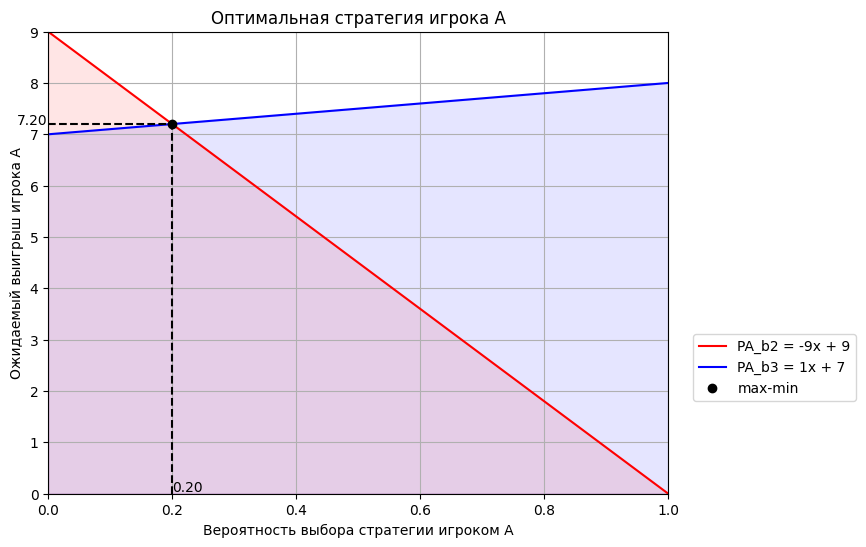

In [12]:
# Отрисовка графиков пересечения.
X = np.linspace(0, 1, 50)
PA_b_first_y = PA_b_first(X)
PA_b_second_y = PA_b_second(X)
max_PA_b_y = np.max(np.concatenate((PA_b_first_y, PA_b_second_y)))

plt.figure(figsize=(8, 6))
plt.title("Оптимальная стратегия игрока A")

PA_b_first_label, PA_b_second_label = reduced_game.player_b_strategy_labels
plt.plot(X, PA_b_first_y, label=f"PA_{PA_b_first_label} = {a - c}x + {c}", color="red")
plt.plot(X, PA_b_second_y, label=f"PA_{PA_b_second_label} = {b - d}x + {d}", color="blue")

# Точка пересечения.
plt.plot(x_intersect, y_intersect, "o", color="black", label="max-min")
# Проекции точки пересечения на оси.
plt.vlines(x_intersect, min(PA_b_first_y), y_intersect, color="black", linestyles='dashed')
plt.hlines(y_intersect, min(X), x_intersect, color="black", linestyles='dashed')
# Ограничение [0, 1] - вероятность.
plt.xlim(0, 1)
# Ограничение на нормализованные элементы матрицы.
plt.ylim(0, max_PA_b_y)
# Подписи осей.
plt.xlabel("Вероятность выбора стратегии игроком A")
plt.ylabel("Ожидаемый выигрыш игрока A")
# Сегменты под графиками.
plt.fill_between(X, PA_b_first_y, color='red', alpha=0.1)
plt.fill_between(X, PA_b_second_y, color='blue', alpha=0.1)
# Отображение значений координат точки пересечения на осях
plt.text(x_intersect, 0.05, f'{x_intersect:.2f}')
plt.text(-0.05, y_intersect, f'{y_intersect:.2f}')

plt.legend(loc=(1.04, 0.2))
plt.grid(True)

In [13]:
# Смешанные стратегии игрока A и цена игры.
assert check_resulted_game_price(reduced_game, y_intersect)
mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_a_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_a_strategy_labels,
        [x_intersect, 1 - x_intersect],
    )),
    player_name="A",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока A   |
+------+------+------+------+------+
|  a1  |  a2  |  a3  |  a4  |  a5  |
+------+------+------+------+------+
| 0.20 | 0.00 | 0.00 | 0.00 | 0.80 |
+------+------+------+------+------+


#### 2.1.2. Для игрока B
Пусть
- $y_2$ - вероятность выбора игроком B стратегии $b_2$.
- $y_3 = 1 - y_2$ - вероятность выбора игроком B стратегии $b_3$.

Ожидаемый проигрыш B при реализации стратегии $a_1$:

$PB_{a1} = c_{12}y_2 + c_{13}y_3 = (c_{12} - c_{13})y_2 + c_{13}$

Ожидаемый проигрыш B при реализации стратегии $a_5$:

$PB_{a5} = c_{52}y_2 + c_{53}y_3 = (c_{52} - c_{53})y_2 + c_{53}$

Оптимальная стратегия A: $PB_{a1} = PB_{a5}$

In [14]:
assert reduced_game.matrix.shape == (2, 2)

(a, b), (c, d) = reduced_game.matrix.tolist()
PB_a_first = lambda x: (a - b) * x + b
PB_a_second = lambda x: (c - d) * x + d

# Находим точку пересечения решая систему Ax = b.
PB_A = np.array([
    [-(a - b), 1],
    [-(c - d), 1],
])
PB_b = np.array([b, d])
(x_intersect, y_intersect) = np.linalg.solve(PB_A, PB_b)

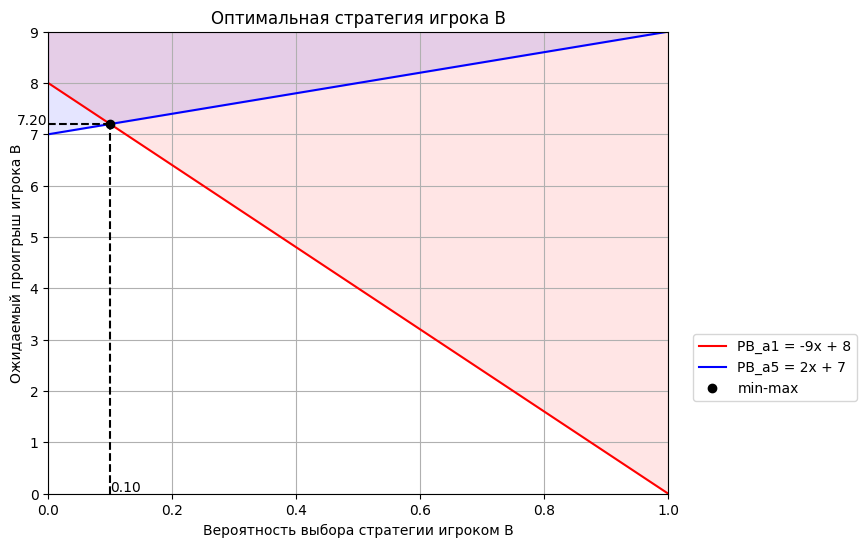

In [15]:
# Отрисовка графиков пересечения.
X = np.linspace(0, 1, 50)
PB_a_first_y = PB_a_first(X)
PB_a_second_y = PB_a_second(X)
max_PB_a_y = np.max(np.concatenate((PB_a_first_y, PB_a_second_y)))

plt.figure(figsize=(8, 6))
plt.title("Оптимальная стратегия игрока B")

PB_a_first_label, PB_a_second_label = reduced_game.player_a_strategy_labels
plt.plot(X, PB_a_first_y, label=f"PB_{PB_a_first_label} = {a - c}x + {b}", color="red")
plt.plot(X, PB_a_second_y, label=f"PB_{PB_a_second_label} = {c - d}x + {d}", color="blue")

# Точка пересечения.
plt.plot(x_intersect, y_intersect, "o", color="black", label="min-max")
# Проекции точки пересечения на оси.
plt.vlines(x_intersect, min(PB_a_first_y), y_intersect, color="black", linestyles='dashed')
plt.hlines(y_intersect, min(X), x_intersect, color="black", linestyles='dashed')
# Ограничение [0, 1] - вероятность.
plt.xlim(0, 1)
# Ограничение на нормализованные элементы матрицы.
plt.ylim(0, max_PB_a_y)
# Подписи осей.
plt.xlabel("Вероятность выбора стратегии игроком B")
plt.ylabel("Ожидаемый проигрыш игрока B")
# Сегменты над графиками.
plt.fill_between(X, PB_a_first_y, max_PB_a_y, color='red', alpha=0.1)
plt.fill_between(X, PB_a_second_y, max_PB_a_y, color='blue', alpha=0.1)
# Отображение значений координат точки пересечения на осях.
plt.text(x_intersect, 0.05, f'{x_intersect:.2f}')
plt.text(-0.05, y_intersect, f'{y_intersect:.2f}')

plt.legend(loc=(1.04, 0.2))
plt.grid(True)

In [16]:
# Смешанные стратегии игрока B и цена игры.
assert check_resulted_game_price(reduced_game, y_intersect)
mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_b_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_b_strategy_labels,
        [x_intersect, 1 - x_intersect],
    )),
    player_name="B",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока B   |
+------+------+------+------+------+
|  b1  |  b2  |  b3  |  b4  |  b5  |
+------+------+------+------+------+
| 0.00 | 0.10 | 0.90 | 0.00 | 0.00 |
+------+------+------+------+------+


### 2.2. Аналитический (матричный) метод

#### 2.2.1. Обратная матрица для игрока A

Для игрока $A$ ($g$ - цена игры; $x_1, ..., x_n$ - смешанные стратегии игрока $A$):

[//]: # (На случай, если LaTeX плохо рендерится в версии Jupyter)
![analytical_A](./img/analytical_A.png) 

In [17]:
analytical_solver = AnalyticalSolver(reduced_game)
first_mixed_strategy, second_mixed_strategy, game_price_value = analytical_solver.player_a_solve()

In [18]:
# Смешанные стратегии игрока A и цена игры.
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_a_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_a_strategy_labels,
        (first_mixed_strategy, second_mixed_strategy),
    )),
    player_name="A",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока A   |
+------+------+------+------+------+
|  a1  |  a2  |  a3  |  a4  |  a5  |
+------+------+------+------+------+
| 0.20 | 0.00 | 0.00 | 0.00 | 0.80 |
+------+------+------+------+------+


#### 2.2.1. Прямая матрица для игрока B
Для игрока $B$ ($h$ - цена игры; $y_1, ..., y_m$ - смешанные стратегии игрока $B$):

[//]: # (На случай, если LaTeX плохо рендерится в версии Jupyter)
![analytical_B](./img/analytical_B.png)

In [19]:
analytical_solver = AnalyticalSolver(reduced_game)
first_mixed_strategy, second_mixed_strategy, game_price_value = analytical_solver.player_b_solve()

In [20]:
# Смешанные стратегии игрока B и цена игры.
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_b_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_b_strategy_labels,
        (first_mixed_strategy, second_mixed_strategy),
    )),
    player_name="B",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока B   |
+------+------+------+------+------+
|  b1  |  b2  |  b3  |  b4  |  b5  |
+------+------+------+------+------+
| 0.00 | 0.10 | 0.90 | 0.00 | 0.00 |
+------+------+------+------+------+


### 2.3. Графический метод (задача ЛП)

<div style="text-align:left;">
    <img src="img/LP_task_02.png" alt="LP_task_02" width="600" height="300">
</div>
<div style="text-align:left;">
    <img src="img/system_matrix_game.png" alt="system_matrix_game" width="300" height="330">
    <img src="img/LP_task_01.png" alt="LP_task_01" width="300" height="330">
</div>

In [21]:
# Подготовка входных данных ЗЛП.
n_rows, n_cols = reduced_game.matrix.shape
input_data = {
    # F = x1 + x2
    "obj_func_coffs": [1] * n_cols,
    # A - матрица сериализуется в массив массивов JSON.
    "constraint_system_lhs": reduced_game.matrix.tolist(),
    # b - вектор-столбец ограничений.
    "constraint_system_rhs": [1] * n_rows,
    # Экстремум, направление оптимизации функции.
    "func_direction": "max"
}

input_path = Path('input_LPP.json')
_ = input_path.write_text(json.dumps(input_data, indent=2))

#### 2.3.1. Двойственная ЗЛП для игрока A

In [22]:
assert reduced_game.matrix.shape == (2, 2)

(a, b), (c, d) = reduced_game.matrix.tolist()
# Прямая для 1-го ограничения.
first_constraint = lambda x_1: (1 / c) - (a / c) * x_1
# Прямая для 2-го ограничения.
second_constraint = lambda x_1: (1 / d) - (b / d) * x_1
# Точка пересечения.
(x_1_intersect, x_2_intersect) = np.linalg.solve(
    np.array([
        [a, c],
        [b, d],
    ]),
    np.array([1, 1]),
)
# Выражаем целевую функцию через xz: x_2 = F - x_1, где F -> min.
player_a_target_function_value = x_1_intersect + x_2_intersect
F_func = lambda x_1: (x_1_intersect + x_2_intersect) - x_1

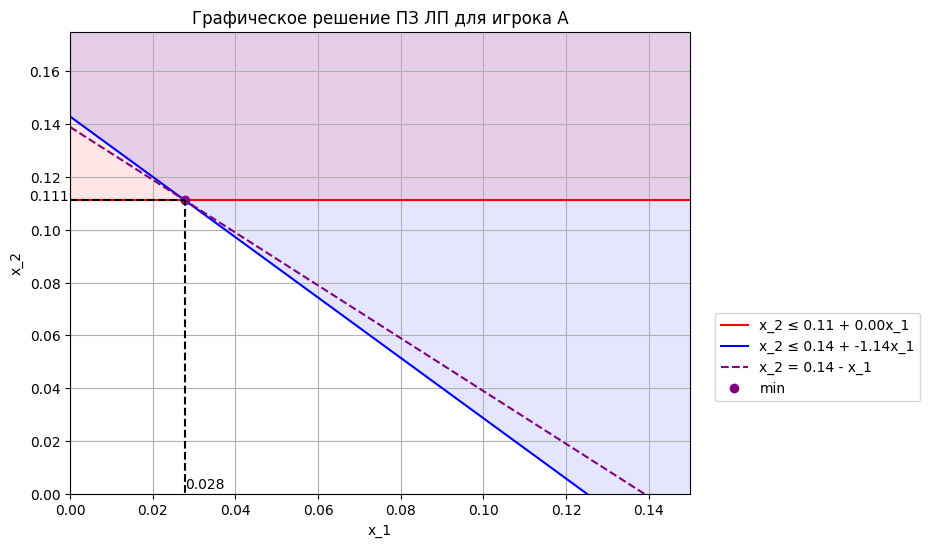

In [23]:
# Отрисовка графиков пересечения.
X = np.linspace(0, 1, 100)
first_constraint_x2 = first_constraint(X)
second_constraint_x2 = second_constraint(X)
F_x2 = F_func(X)
max_x2 = np.max(np.concatenate((first_constraint_x2, second_constraint_x2))) + 0.15

plt.figure(figsize=(8, 6))
plt.title("Графическое решение ПЗ ЛП для игрока A")

plt.plot(X, first_constraint_x2, label=f"x_2 ≤ {1 / c:.2f} + {- a / c:.2f}x_1", color="red")
plt.plot(X, second_constraint_x2, label=f"x_2 ≤ {1 / d:.2f} + {- b / d:.2f}x_1", color="blue")
plt.plot(X, F_x2, "--", label=f"x_2 = {x_1_intersect + x_2_intersect:.2f} - x_1", color="purple")

# Точка пересечения.
plt.plot(x_1_intersect, x_2_intersect, "o", color="purple", label="min")
# Проекции точки пересечения на оси.
plt.vlines(x_1_intersect, min(second_constraint_x2), x_2_intersect, color="black", linestyles='dashed')
plt.hlines(x_2_intersect, min(X), x_1_intersect, color="black", linestyles='dashed')
# Ограничения на неотрицательные решения.
plt.xlim(0, 0.15)
plt.ylim(0, 0.175)
# Подписи осей.
plt.xlabel("x_1")
plt.ylabel("x_2")
# Сегменты над графиками.
plt.fill_between(X, first_constraint_x2, max_x2, color='red', alpha=0.1)
plt.fill_between(X, second_constraint_x2,max_x2, color='blue', alpha=0.1)

# Отображение значений координат точки пересечения на осях.
plt.text(x_1_intersect, 0.002, f'{x_1_intersect:.3f}')
plt.text(-0.01, x_2_intersect, f'{x_2_intersect:.3f}')

plt.legend(loc=(1.04, 0.2))
plt.grid(True)

In [24]:
# Смешанные стратегии игрока A и цена игры.
game_price_value = 1 / player_a_target_function_value
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

player_a_mixed_strategies = [var_value * game_price_value for var_value in [x_1_intersect, x_2_intersect]]
player_a_mixed_strategies = player_a_mixed_strategies[:len(reduced_game.player_a_strategy_labels)]
mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_a_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_a_strategy_labels,
        player_a_mixed_strategies,
    )),
    player_name="A",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока A   |
+------+------+------+------+------+
|  a1  |  a2  |  a3  |  a4  |  a5  |
+------+------+------+------+------+
| 0.20 | 0.00 | 0.00 | 0.00 | 0.80 |
+------+------+------+------+------+


#### 2.3.2. Прямая ЗЛП для игрока B

In [25]:
assert reduced_game.matrix.shape == (2, 2)

(a, b), (c, d) = reduced_game.matrix.tolist()
# Прямая для 1-го ограничения.
first_constraint = lambda x_1: (1 / b) - (a / b) * x_1
# Прямая для 2-го ограничения.
second_constraint = lambda x_1: (1 / d) - (c / d) * x_1
# Точка пересечения.
(x_1_intersect, x_2_intersect) = np.linalg.solve(
    np.array([
        [a, b],
        [c, d],
    ]),
    np.array([1, 1]),
)
# Выражаем целевую функцию через xz: x_2 = F - x_1, где F -> max.
player_b_target_function_value = x_1_intersect + x_2_intersect
F_func = lambda x_1: (x_1_intersect + x_2_intersect) - x_1

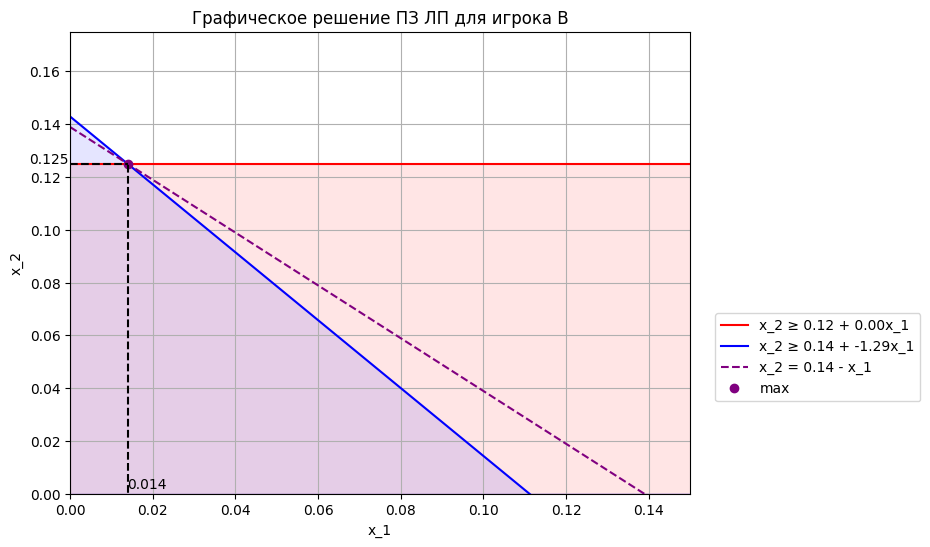

In [26]:
# Отрисовка графиков пересечения.
X = np.linspace(0, 1, 100)
first_constraint_x2 = first_constraint(X)
second_constraint_x2 = second_constraint(X)
F_x2 = F_func(X)

plt.figure(figsize=(8, 6))
plt.title("Графическое решение ПЗ ЛП для игрока B")

plt.plot(X, first_constraint_x2, label=f"x_2 ≥ {1 / b:.2f} + {- a / b:.2f}x_1", color="red")
plt.plot(X, second_constraint_x2, label=f"x_2 ≥ {1 / d:.2f} + {- c / d:.2f}x_1", color="blue")
plt.plot(X, F_x2, "--", label=f"x_2 = {x_1_intersect + x_2_intersect:.2f} - x_1", color="purple")

# Точка пересечения.
plt.plot(x_1_intersect, x_2_intersect, "o", color="purple", label="max")
# Проекции точки пересечения на оси.
plt.vlines(x_1_intersect, min(second_constraint_x2), x_2_intersect, color="black", linestyles='dashed')
plt.hlines(x_2_intersect, min(X), x_1_intersect, color="black", linestyles='dashed')
# Ограничения на неотрицательные решения.
plt.xlim(0, 0.15)
plt.ylim(0, 0.175)
# Подписи осей.
plt.xlabel("x_1")
plt.ylabel("x_2")
# Сегменты над графиками.
plt.fill_between(X, first_constraint_x2, color='red', alpha=0.1)
plt.fill_between(X, second_constraint_x2, color='blue', alpha=0.1)

# Отображение значений координат точки пересечения на осях
plt.text(x_1_intersect, 0.002, f'{x_1_intersect:.3f}')
plt.text(-0.01, x_2_intersect, f'{x_2_intersect:.3f}')

plt.legend(loc=(1.04, 0.2))
plt.grid(True)

In [27]:
# Смешанные стратегии игрока B и цена игры.
game_price_value = 1 / player_b_target_function_value
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

player_b_mixed_strategies = [var_value * game_price_value for var_value in [x_1_intersect, x_2_intersect]]
player_b_mixed_strategies = player_b_mixed_strategies[:len(reduced_game.player_b_strategy_labels)]
mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_b_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_b_strategy_labels,
        player_b_mixed_strategies,
    )),
    player_name="B",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока B   |
+------+------+------+------+------+
|  b1  |  b2  |  b3  |  b4  |  b5  |
+------+------+------+------+------+
| 0.00 | 0.10 | 0.90 | 0.00 | 0.00 |
+------+------+------+------+------+


### 2.4. Симплекс-метод (задача ЛП)

<div style="text-align:left;">
    <img src="img/LP_simplex.png" alt="LP_task_02" width="600" height="300">
</div>


#### 2.4.1. Двойственная задача ЛП для игрока A

In [28]:
player_a_problem = DualProblem(input_path)

F = b^T⋅x -> min,
A^T⋅x >= c^T,
x1, x2, ..., xn >= 0
b^T = [1 1]
A^T =
[[0 9]
 [8 7]],
c^T = [1 1].


In [29]:
player_a_solution = player_a_problem.solve()
player_a_var_values, player_a_target_function_value = player_a_solution

Процесс решения:
Поиск опорного решения: 
Исходная симплекс-таблица:
+----+---------+---------+---------+
|    |   Si0   |    x1   |    x2   |
+----+---------+---------+---------+
| x3 | -1.0000 |  0.0000 | -9.0000 |
| x4 | -1.0000 | -8.0000 | -7.0000 |
| F  |  0.0000 | -1.0000 | -1.0000 |
+----+---------+---------+---------+
Разрешающая строка: x3
Разрешающий столбец: x2
+----+---------+---------+---------+
|    |   Si0   |    x1   |    x3   |
+----+---------+---------+---------+
| x2 |  0.1111 | -0.0000 | -0.1111 |
| x4 | -0.2222 | -8.0000 | -0.7778 |
| F  |  0.1111 | -1.0000 | -0.1111 |
+----+---------+---------+---------+
Разрешающая строка: x4
Разрешающий столбец: x1
+----+--------+---------+---------+
|    |  Si0   |    x4   |    x3   |
+----+--------+---------+---------+
| x2 | 0.1111 | -0.0000 | -0.1111 |
| x1 | 0.0278 | -0.1250 |  0.0972 |
| F  | 0.1389 | -0.1250 | -0.0139 |
+----+--------+---------+---------+
Опорное решение найдено!
x4 = x3 = 0, 
x2 = 0.111, x1 = 0.028
Целев

In [30]:
# Смешанные стратегии игрока A и цена игры.
game_price_value = 1 / player_a_target_function_value
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

player_a_mixed_strategies = [var_value * game_price_value for var_value in player_a_var_values]
player_a_mixed_strategies = player_a_mixed_strategies[:len(reduced_game.player_a_strategy_labels)]
mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_a_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_a_strategy_labels,
        player_a_mixed_strategies,
    )),
    player_name="A",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока A   |
+------+------+------+------+------+
|  a1  |  a2  |  a3  |  a4  |  a5  |
+------+------+------+------+------+
| 0.20 | 0.00 | 0.00 | 0.00 | 0.80 |
+------+------+------+------+------+


#### 2.4.2. Прямая задача ЛП для игрока B

In [31]:
player_b_problem = SimplexProblem(input_path)
player_b_problem

F = c⋅x -> max,
Ax <= b,
x1,x2, ..., xn >= 0
c^T = [-1 -1],
A =
[[0 8]
 [9 7]],
b^T = [1 1].

In [32]:
player_b_solution = player_b_problem.solve()
player_b_var_values, player_b_target_function_value = player_b_solution

Процесс решения:
Поиск опорного решения: 
Исходная симплекс-таблица:
+----+--------+--------+--------+
|    |  Si0   |   x1   |   x2   |
+----+--------+--------+--------+
| x3 | 1.0000 | 0.0000 | 8.0000 |
| x4 | 1.0000 | 9.0000 | 7.0000 |
| F  | 0.0000 | 1.0000 | 1.0000 |
+----+--------+--------+--------+
Опорное решение найдено!
x1 = x2 = 0, 
x3 = 1.000, x4 = 1.000
Целевая функция: F = 0.000
Поиск оптимального решения:
Разрешающая строка: x4
Разрешающий столбец: x1
+----+---------+---------+--------+
|    |   Si0   |    x4   |   x2   |
+----+---------+---------+--------+
| x3 |  1.0000 | -0.0000 | 8.0000 |
| x1 |  0.1111 |  0.1111 | 0.7778 |
| F  | -0.1111 | -0.1111 | 0.2222 |
+----+---------+---------+--------+
Разрешающая строка: x3
Разрешающий столбец: x2
+----+---------+---------+---------+
|    |   Si0   |    x4   |    x3   |
+----+---------+---------+---------+
| x2 |  0.1250 | -0.0000 |  0.1250 |
| x1 |  0.0139 |  0.1111 | -0.0972 |
| F  | -0.1389 | -0.1111 | -0.0278 |
+----+--

In [33]:
# Смешанные стратегии игрока B и цена игры.
game_price_value = 1 / player_b_target_function_value
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

player_b_mixed_strategies = [var_value * game_price_value for var_value in player_b_var_values]
player_b_mixed_strategies = player_b_mixed_strategies[:len(reduced_game.player_b_strategy_labels)]
mixed_strategies = get_resulted_mixed_strategies(
    player_labels=game_matrix.player_b_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_b_strategy_labels,
        player_b_mixed_strategies,
    )),
    player_name="B",
)
print(mixed_strategies)

Цена игры: 7 <= 7.200 <= 8


+----------------------------------+
|   Смешанные стратегии игрока B   |
+------+------+------+------+------+
|  b1  |  b2  |  b3  |  b4  |  b5  |
+------+------+------+------+------+
| 0.00 | 0.10 | 0.90 | 0.00 | 0.00 |
+------+------+------+------+------+


### 3. Расчёт цены игры исходной матрицы
Вспомним изначальную заданную матрицу игры, до нормализации и найдём её цену игры и смешанные стратегии игроков.

In [34]:
# Вычитаем ранее добавленное слагаемое нормализации.
game_matrix.matrix -= normalizer
game_matrix

+---------------------------------------------------------+
|               Таблица стратегий (игрока А)              |
+----------------+----+----+----+----+----+---------------+
|   Стратегии    | b1 | b2 | b3 | b4 | b5 | MIN выигрыш A |
+----------------+----+----+----+----+----+---------------+
|       a1       | 4  | -3 | 5  | 6  | 4  |       -3      |
|       a2       | 6  | 5  | -3 | 4  | 7  |       -3      |
|       a3       | 6  | 5  | -3 | -3 | 5  |       -3      |
|       a4       | -3 | -3 | 4  | 4  | 4  |       -3      |
|       a5       | 7  | 6  | 4  | 5  | 6  |       4       |
| MAX проигрыш B | 7  | 6  | 5  | 6  | 7  |               |
+----------------+----+----+----+----+----+---------------+

In [35]:
print(f"Нижняя цена игры:  {game_matrix.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {game_matrix.highest_game_price[1]}")

Нижняя цена игры:  4
Верхняя цена игры: 5


In [36]:
original_game_price: float = game_price_value - normalizer
print(f"Цена игры исходной матрицы: {original_game_price:.2f}")

Цена игры исходной матрицы: 4.20
